## Variational autoencoder

In [1]:
import numpy as np
# for a gpu version 
# import cupy as np

from matplotlib import pyplot as plt
%matplotlib inline



In [ ]:
# we use the lightweight deep learning library dp
# you have to put dp.py in the same folder as this noebook
# you can download it from
# https://gitlab.com/deep.TEACHING/educational-materials/-/blob/master/notebooks/differentiable-programming/dp.py
# if you have downloaded the complete deep teaching git repo you find it in the folder ../differentiable-programming/

import dp # differentiable programming module
from dp import Node

In [4]:
#data_path = "/Users/christian/data/mnist_csv/"
data_path = "/home/chris/Downloads/"
# get the data from
#   https://pjreddie.com/projects/mnist-in-csv/

try:
    train_data_mnist
except NameError:
    train_data_mnist = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
    test_data_mnist = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")


In [5]:
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 5 # dimensionality of the latent code z.
intermediate_dim = 128 # Size of the hidden layer.
epochs = 30
image_dim = int(np.sqrt(original_dim))
image_dim

28

In [6]:
def get_xy_mnist(data_mnist=train_data_mnist):
    x_train = train_data_mnist[:,1:]
    x_train = x_train / 255. 
    #x_train = x_train.reshape((-1, image_dim, image_dim))
    y_train = train_data_mnist[:,0]
    return x_train, y_train

In [7]:
x_train_, y_train_ = get_xy_mnist()
x_test_, y_test = get_xy_mnist(test_data_mnist)

In [9]:
nb_classes = 10
m = y_train_.shape[0]
y_train = np.zeros((m, nb_classes), dtype=int)
y_train[np.arange(m), y_train_.astype(int)] = 1

In [10]:
batch_size = 2**7
batch_size

128

In [11]:
def random_batch(x_train=x_train, y_train=y_train, batch_size=batch_size):
    n = x_train.shape[0]
    indices = np.random.randint(0,n, size=batch_size)
    return x_train[indices], y_train[indices]

### Exercise: Implement the loss function




### Loss
Recap: We use the (negative) Variational Lower Bound as loss:

$$
\mathcal L^{(i)} =\text{ELBO}^{(i)} = \mathbb E_{q(z\mid x^{(i)}; \phi)}[\log p(x^{(i)} \mid z^{(i)}; \theta)] - D_{KL}[q(z^{(i)} \mid x^{(i)}; \phi) \mid \mid p(z^{(i)})]
$$

#### Note on the second term 

Here $q(z^{(i)} \mid x^{(i)}; \phi)$ and $p(z^{(i)})$ are Gaussian:
- prior: $p(z^{(i)})=\mathcal N(0,\mathbb 1)$
 - $\mathbb 1$ diagonal matrix with $1$s.
- $q(z^{(i)} \mid x^{(i)}; \phi) = \mathcal N\left(\mu(x^{(i)}),\Sigma^2(x^{(i)})\right)$
 - the diagonal matrix $\Sigma^2(x^{(i)})$ has entries $\sigma^2_j(x^{(i)})$.
 
The encoder NN computes the means $\mu_j(x^{(i)})$ and stds $\sigma_j(x^{(i)})$ of the normal distribution from which the $z$-components are sampled. 

For such Gaussians the Kullback-Leiber Divergence can be computed analytically:

$$
D_{KL}[q(z^{(i)} \mid x^{(i)}; \phi) \mid \mid p(z^{(i)})] =
 \sum_j \left( - \log \sigma_j ( x^{(i)}) + \frac{\sigma_j^2 ( x^{(i)})+ \mu_j^2 ( x^{(i)})-1}{2} \right)
$$
- $j$ is the index for the dimensions of $z$


#### Note on the first term $\mathbb E_{q(z^{(i)}\mid x^{(i)}, \phi)} [\log p(x|z,\theta)]$

The encoder NN computes the means $\mu_j(x^{(i)})$ and stds $\sigma_j(x^{(i)})$ of the normal distribution from which $z$ is sampled. This samples are used in the MC Estimator for the expectation. For each data point in a mini batch a $z$ is sampled. The decoder NN takes the $z$s for reconstruct $x$. For each $x$ the decoder NN computes a probability $\pi$ (value between 0 and 1) for each pixel. $\pi$ is the probability that the pixel is 1, i.e. $p(x=1|z,\theta)=v$. $\pi$ is a deterministic function of $z$ and $\theta$: $\pi(z,\theta)$     
In the data generating process from $\pi$ is sampled then the realized pixel have value 0 or 1.     
The data image pixel value $x \in \{0,1\}$ determines if we should take $\log p(x=1|z,\theta)=\log \pi$ or $\log p(x=0|z,\theta)=\log (1-\pi)$ for the loss. This selection (in the cross entropy formula) is done with the trick of multiplying $x$ resp. $(1-x)$.

In [12]:
class VAE(dp.Model):
    
    def __init__(self, original_dim=original_dim, 
                 intermediate_dim=intermediate_dim, 
                 latent_dim=latent_dim):
        super(VAE, self).__init__()
        
        # encoder param
        self.fc1 = self.ReLu_Layer(original_dim, intermediate_dim, "fc1")
        self.fc21 = self.Linear_Layer(intermediate_dim, latent_dim, "fc21")
        self.fc22 = self.Linear_Layer(intermediate_dim, latent_dim, "fc22")
        
        # decoder param
        self.fc3 = self.ReLu_Layer(latent_dim, intermediate_dim, "fc3")
        self.fc4 = self.Linear_Layer(intermediate_dim, original_dim, "fc4")
    
    def encoder(self, x):
        h1 = self.fc1(x)
        return self.fc21(h1), self.fc22(h1)
    
    def decoder(self, z):
        h3 = self.fc3(z)
        return self.fc4(h3).sigmoid()

    # Sampling from the distribution q(z | x) = N(loc, scale)
    # with reparametrization trick.
    def sampling(mu, logvar):
        # as exercise
        raise NotImplementedError()
    
    def elbo_binomial(x, x_decoded_mean, z_mean, z_logvar):
        # as exercise
        raise NotImplementedError()
        
    def complete_result(self, x, y=None):
        assert isinstance(x, Node)
        x_reconstructed, z, mu, logvar = self.encoder_decoder(x)
        loss = VAE.elbo_binomial(x, x_reconstructed, mu, logvar)
        return loss, x_reconstructed, z, mu, logvar
             
    def loss(self, x, y=None):
        loss, x_reconstructed, z, mu, logvar = self.complete_result(x)
        return loss
        
    def encoder_decoder(self, x=None): 
        assert isinstance(x, Node)
        mu, logvar = self.encoder(x)
        z = VAE.sampling(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z, mu, logvar 
    

In [15]:
model = VAE()

In [18]:
optimizer = dp.optimizer.RMS_Prop(model, x_train, y_train, {"alpha":0.001, "beta2":0.9}, batch_size=batch_size)
optimizer.train(steps=2000, print_each=100)

iteration	loss
1 	 754.6810172775514
100 	 189.01065687527876
200 	 163.41005855498807
300 	 152.7318255216338
400 	 153.5977037412187
500 	 152.2803389768308
600 	 138.98738415334526
700 	 142.7251023159316
800 	 144.5236833344694
900 	 141.99811778687825
1000 	 132.20779062264782
1100 	 134.96110252706168
1200 	 137.9260590258515
1300 	 129.8087122333456
1400 	 131.13113232144732
1500 	 128.50145046899456
1600 	 132.084567772302
1700 	 130.73433745254164
1800 	 132.5080785321756
1900 	 134.8022601180447
2000 	 134.01236115191807


array([[134.01236115]])

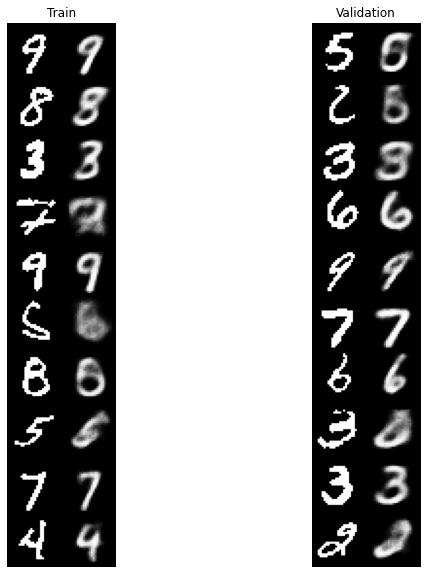

In [19]:
# TODO: new image plots!

b_size = 10
x_, y_ = random_batch(batch_size=b_size)
x_1, y_1 = random_batch(x_test, y_test, batch_size=b_size)

fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_, x_1], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = image_dim
    figure = np.zeros((digit_size * n, digit_size * 2))
    
    loss, x_reconstructed, z, mu, logvar = model.complete_result(x=Node(data))
    decoded = x_reconstructed.value
    decoded = np.clip(decoded,0,1)
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()


#### Exercise: Generating new images

Generate new images from the model.

In [20]:
n_samples = 10
# Todo as exercise
sampled_im_mean = None # Todo as exercise

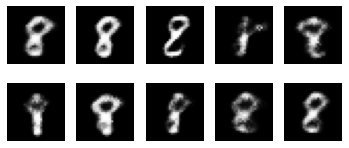

In [34]:
# TODO: new image plots!
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()


In [23]:
# VAE conditioned on class label
class Conditional_VAE(dp.Model):
    def __init__(self, original_dim=original_dim, 
                 intermediate_dim=intermediate_dim, 
                 latent_dim=latent_dim,
                 nb_classes=nb_classes
                ):
        super(Conditional_VAE, self).__init__()
        
        # encoder param
        self.fc1 = self.ReLu_Layer(original_dim+nb_classes, intermediate_dim, "fc1")
        self.fc21 = self.Linear_Layer(intermediate_dim, latent_dim, "fc21")
        self.fc22 = self.Linear_Layer(intermediate_dim, latent_dim, "fc22")
        
        # decoder param
        self.fc3 = self.ReLu_Layer(latent_dim+nb_classes, intermediate_dim, "fc3")
        self.fc4 = self.Linear_Layer(intermediate_dim, original_dim, "fc4")
    
    def encoder(self, x, y):
        xy = x.concatenate(y, axis=1)
        h1 = self.fc1(xy)
        return self.fc21(h1), self.fc22(h1)
    
    def decoder(self, z, y):
        zy = z.concatenate(y, axis=1)
        h3 = self.fc3(zy)
        return self.fc4(h3).sigmoid()

    def complete_result(self, x, y):
        assert isinstance(x, Node)
        x_reconstructed, z, mu, logvar = self.encoder_decoder(x, y)
        loss = VAE.elbo_binomial(x, x_reconstructed, mu, logvar)
        return loss, x_reconstructed, z, mu, logvar
             
    def loss(self, x, y):
        loss, x_reconstructed, z, mu, logvar = self.complete_result(x, y)
        return loss
        
    def encoder_decoder(self, x, y): 
        assert isinstance(x, Node)
        assert isinstance(y, Node)
        mu, logvar = self.encoder(x, y)
        z = VAE.sampling(mu, logvar)
        x_reconstructed = self.decoder(z, y)
        return x_reconstructed, z, mu, logvar 


In [24]:
cmodel = Conditional_VAE()

In [25]:
optimizer = dp.optimizer.RMS_Prop(cmodel, x_train, y_train, 
                                  {"alpha":0.001, "beta2":0.9}, batch_size=batch_size)
optimizer.train(steps=3000, print_each=100)

iteration	loss
1 	 644.8099458873851
100 	 191.58626643629924
200 	 160.82652178115032
300 	 146.1062535997692
400 	 144.77274393886756
500 	 138.4928371437679
600 	 134.48543117346514
700 	 127.03498135399278
800 	 131.81428545800082
900 	 127.81752729646351
1000 	 126.98442030748525
1100 	 126.87265796853298
1200 	 132.9127311453287
1300 	 123.58075748303786
1400 	 123.48363877931138
1500 	 128.92065755024004
1600 	 122.43852188094728
1700 	 123.35481531919156
1800 	 122.6666255968586
1900 	 120.7470643382134
2000 	 117.92753607911844
2100 	 111.88843046889379
2200 	 121.42530627030216
2300 	 117.13705206295303
2400 	 121.2974065052953
2500 	 125.51833136054651
2600 	 116.06330112343903
2700 	 116.3950736282919
2800 	 118.8746651104017
2900 	 116.95019949450807
3000 	 123.7013209110921


array([[123.70132091]])

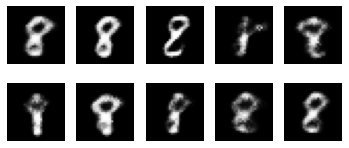

In [33]:
# sampled_image_mean has size 10 x 784 with 10
nb_samples = 10
z = np.random.normal(size=(n_samples, latent_dim))

# Ths is the number which is generated as image
label = 8


y = np.zeros([nb_samples, nb_classes])
y[:, label] = 3.
sampled_im_mean = cmodel.decoder(Node(z), Node(y)).value

# TODO: new image plots!
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()